<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/06-dl-pytorch-food/food_image_classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import zipfile
import io

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [ ]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using this device: {device}')

Using this device: cuda


In [3]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip"

response = requests.get(url)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

zip_file.extractall("/content/")


In [4]:
# data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(root='/content/dataset/train', transform=train_transform)
val_dataset = ImageFolder(root='/content/dataset/val', transform=val_test_transform)
test_dataset = ImageFolder(root='/content/dataset/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Train samples: {len(train_dataset)}')
print(f'Valid samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 8960
Valid samples: 2240
Test samples: 2800


In [5]:
from collections import Counter
import os

def count_images_per_class(folder_path):
    counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            counts[class_name] = len(os.listdir(class_folder))
    return counts

train_counts = count_images_per_class('/content/dataset/train')
val_counts = count_images_per_class('/content/dataset/val')
test_counts = count_images_per_class('/content/dataset/test')

print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)
print("Test class distribution:", test_counts)

Train class distribution: {'Hot Dog': 640, 'omelette': 640, 'Fries': 640, 'apple_pie': 640, 'Taquito': 640, 'Crispy Chicken': 640, 'Sandwich': 640, 'Donut': 640, 'Baked Potato': 640, 'chicken_curry': 640, 'sushi': 640, 'ice_cream': 640, 'Taco': 640, 'cheesecake': 640}
Validation class distribution: {'Hot Dog': 160, 'omelette': 160, 'Fries': 160, 'apple_pie': 160, 'Taquito': 160, 'Crispy Chicken': 160, 'Sandwich': 160, 'Donut': 160, 'Baked Potato': 160, 'chicken_curry': 160, 'sushi': 160, 'ice_cream': 160, 'Taco': 160, 'cheesecake': 160}
Test class distribution: {'Hot Dog': 200, 'omelette': 200, 'Fries': 200, 'apple_pie': 200, 'Taquito': 200, 'Crispy Chicken': 200, 'Sandwich': 200, 'Donut': 200, 'Baked Potato': 200, 'chicken_curry': 200, 'sushi': 200, 'ice_cream': 200, 'Taco': 200, 'cheesecake': 200}


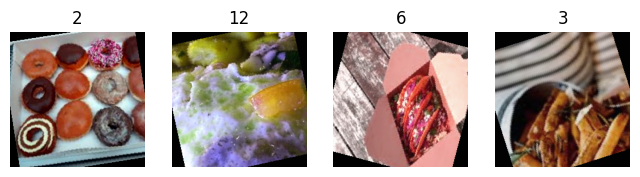

In [6]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img):
    return img * std + mean

examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8,3))

for i in range(4):
    plt.subplot(1,4,i+1)
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).clamp(0,1)
    plt.imshow(img)
    plt.title(str(labels[i].item()))
    plt.axis('off')

plt.show()

# Transfer Learning Model

In [7]:
num_classes = 14
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


# Training setup

In [8]:
criterion = nn.CrossEntropyLoss()
# AdamW instead of Adam + CosineAnnealingLR
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
# CosineAnnealingLR gradually decreases LR following a cosine curve
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


class EarlyStopping:
  def __init__(self, patience=5):
      self.patience = patience
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss is None or val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter == self.patience:
        self.early_stop = True

# Training the model

In [9]:
def evaluate(model, dataloader):
  model.eval()
  val_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)

      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return val_loss/len(dataloader), correct/total

# Training and validate

In [10]:
epochs = 35
early_stopping = EarlyStopping(patience=3)

for epoch in range(epochs):
  model.train()
  running_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  scheduler.step()
  val_loss, val_acc = evaluate(model, val_loader)
  print(f'Epoch {epoch+1}, Train loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  early_stopping(val_loss)
  if early_stopping.early_stop:
      print("Early stopping triggered.")
      break

Epoch 1, Train loss: 1.6906, Val Loss: 1.0528, Val Acc: 0.6786
Epoch 2, Train loss: 1.2719, Val Loss: 0.8815, Val Acc: 0.7174
Epoch 3, Train loss: 1.1509, Val Loss: 0.8000, Val Acc: 0.7509
Epoch 4, Train loss: 1.1379, Val Loss: 0.8061, Val Acc: 0.7460
Epoch 5, Train loss: 1.0971, Val Loss: 0.7417, Val Acc: 0.7607
Epoch 6, Train loss: 1.0613, Val Loss: 0.8733, Val Acc: 0.7143
Epoch 7, Train loss: 1.0649, Val Loss: 0.7429, Val Acc: 0.7603
Epoch 8, Train loss: 1.0184, Val Loss: 0.7347, Val Acc: 0.7683
Epoch 9, Train loss: 0.9933, Val Loss: 0.7330, Val Acc: 0.7603
Epoch 10, Train loss: 1.0007, Val Loss: 0.7265, Val Acc: 0.7683
Epoch 11, Train loss: 0.9937, Val Loss: 0.7260, Val Acc: 0.7629
Epoch 12, Train loss: 0.9969, Val Loss: 0.7510, Val Acc: 0.7580
Epoch 13, Train loss: 1.0095, Val Loss: 0.7569, Val Acc: 0.7522
Epoch 14, Train loss: 1.0120, Val Loss: 0.7201, Val Acc: 0.7656
Epoch 15, Train loss: 1.0390, Val Loss: 0.7471, Val Acc: 0.7500
Epoch 16, Train loss: 1.0329, Val Loss: 0.7274, V

In [11]:
# baseline: feature extractor
torch.save(model.state_dict(), 'baseline_model.pth')
print("Baseline model saved")

Baseline model saved


In [12]:
# redefine the model
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 14)  # 14 classi, stesso numero usato nel training

# loading the trained one
# model.load_state_dict(torch.load('model.pth'))

# moving to gpu
# model.to(device)


In [13]:
# Helper for clean code
def set_optimizer(lr, weight_decay=1e-4, t_max=10):
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)
    return optimizer, scheduler

# Fine tuning

In [14]:
early_stopping = EarlyStopping(patience=3)

for epoch in range(epochs):
    # Gradual unfreezing
    # Phase 1: classifier only
    if epoch == 0:
        for name, param in model.named_parameters():
            param.requires_grad = ("fc" in name)
        optimizer, scheduler = set_optimizer(lr=1e-3)
    # Phase 2: fc + layer4
    elif epoch == 5:
        for name, param in model.named_parameters():
            param.requires_grad = ("fc" in name or "layer4" in name)
        optimizer, scheduler = set_optimizer(lr=1e-4)
    # Phase 3: fc + layer4 + layer3
    elif epoch == 10:
        for name, param in model.named_parameters():
            param.requires_grad = ("fc" in name or "layer4" in name or "layer3" in name)
        optimizer, scheduler = set_optimizer(lr=1e-5)
    # Training loop
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping + best model checkpoint
    if early_stopping.best_loss is None or val_loss < early_stopping.best_loss:
      torch.save(model.state_dict(), "best_finetuned_model.pth")
      print("Best fine-tuned model saved")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


[Epoch 1] Train Loss: 1.0550, Val Loss: 0.7620, Val Acc: 0.7522
Best fine-tuned model saved
[Epoch 2] Train Loss: 1.0336, Val Loss: 0.7353, Val Acc: 0.7603
Best fine-tuned model saved
[Epoch 3] Train Loss: 1.0226, Val Loss: 0.6926, Val Acc: 0.7714
Best fine-tuned model saved
[Epoch 4] Train Loss: 1.0064, Val Loss: 0.7581, Val Acc: 0.7406
[Epoch 5] Train Loss: 0.9793, Val Loss: 0.7284, Val Acc: 0.7594
[Epoch 6] Train Loss: 0.9842, Val Loss: 0.6475, Val Acc: 0.7893
Best fine-tuned model saved
[Epoch 7] Train Loss: 0.7745, Val Loss: 0.5879, Val Acc: 0.8237
Best fine-tuned model saved
[Epoch 8] Train Loss: 0.6693, Val Loss: 0.5090, Val Acc: 0.8371
Best fine-tuned model saved
[Epoch 9] Train Loss: 0.5927, Val Loss: 0.4389, Val Acc: 0.8607
Best fine-tuned model saved
[Epoch 10] Train Loss: 0.5308, Val Loss: 0.4542, Val Acc: 0.8607
[Epoch 11] Train Loss: 0.4407, Val Loss: 0.4153, Val Acc: 0.8661
Best fine-tuned model saved
[Epoch 12] Train Loss: 0.3938, Val Loss: 0.4037, Val Acc: 0.8705
Best 

In [15]:
# load best fine-tuned model
model.load_state_dict(torch.load("best_finetuned_model.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

In [17]:
class_names = train_loader.dataset.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# F1-score macro
f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1-score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Test Accuracy: 88.36%
Macro F1-score: 0.8838
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.92      0.93      0.92       200
Crispy Chicken       0.93      0.88      0.90       200
         Donut       0.93      0.96      0.95       200
         Fries       0.94      0.94      0.94       200
       Hot Dog       0.82      0.88      0.85       200
      Sandwich       0.88      0.84      0.86       200
          Taco       0.77      0.77      0.77       200
       Taquito       0.87      0.85      0.86       200
     apple_pie       0.82      0.86      0.84       200
    cheesecake       0.87      0.92      0.89       200
 chicken_curry       0.93      0.89      0.91       200
     ice_cream       0.88      0.88      0.88       200
      omelette       0.87      0.88      0.87       200
         sushi       0.95      0.90      0.92       200

      accuracy                           0.88      2800
     macro avg       0.88      0.8

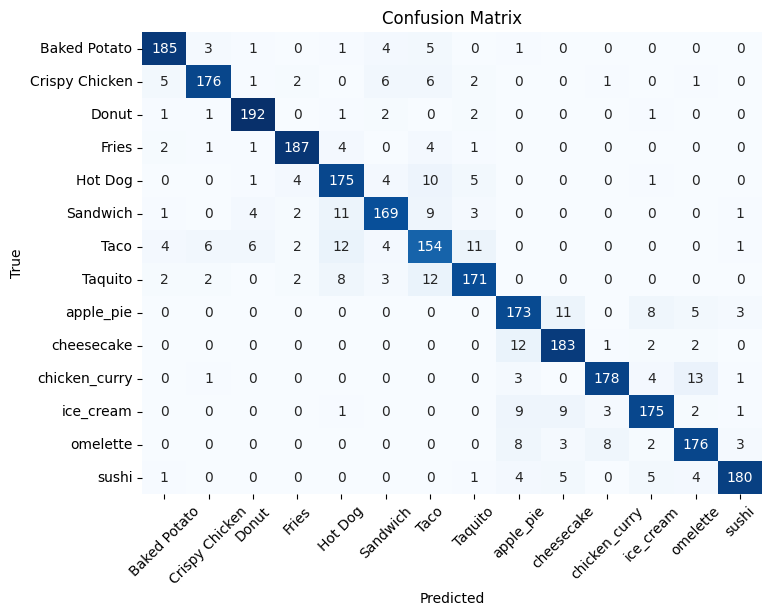

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

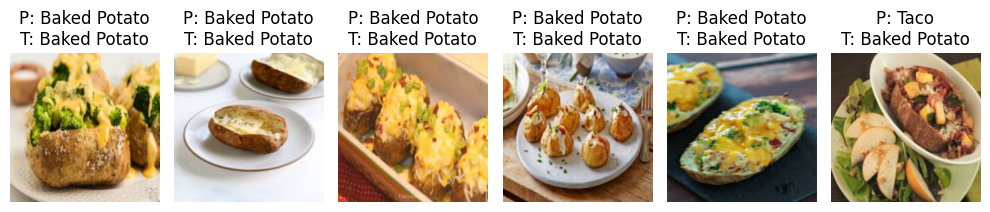

In [19]:
examples = iter(test_loader)
images, labels = next(examples)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 4))
for i in range(min(6, len(images))):
    plt.subplot(1, 6, i+1)
    img = denormalize(images[i].cpu())
    img = img.permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(f"P: {class_names[predicted[i].cpu().item()]}\nT: {class_names[labels[i].cpu().item()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()